In [1]:
# Specify CUDA device
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

# Set 64-bit precision
from jax import jit, config, grad
config.update("jax_enable_x64", True)

# Check we're running on GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import time
import numpy as np
import jax.numpy as jnp
import optax
import jaxopt

from matplotlib import pyplot as plt
from importlib import reload

import scatcovjax.Sphere_lib as sphlib
import scatcovjax.Synthesis_lib as synlib
import scatcovjax.Fast_scattering_lib as scatlib
from s2wav.filter_factory.filters import filters_directional_vectorised

import s2fft
import s2wav
from s2wav.transforms import jax_wavelets_precompute as wavelets

import scatcovjax.plotting as plot
plot.notebook_plot_format()

gpu


# Parameters

In [2]:
sampling = "mw"
multiresolution = True
reality = True

L = 256
N = 2
J_min = 0

J_max = s2wav.utils.shapes.j_max(L)
J = J_max - J_min + 1
print(f'{J=} {J_max=}')


J=9 J_max=8


# Filters

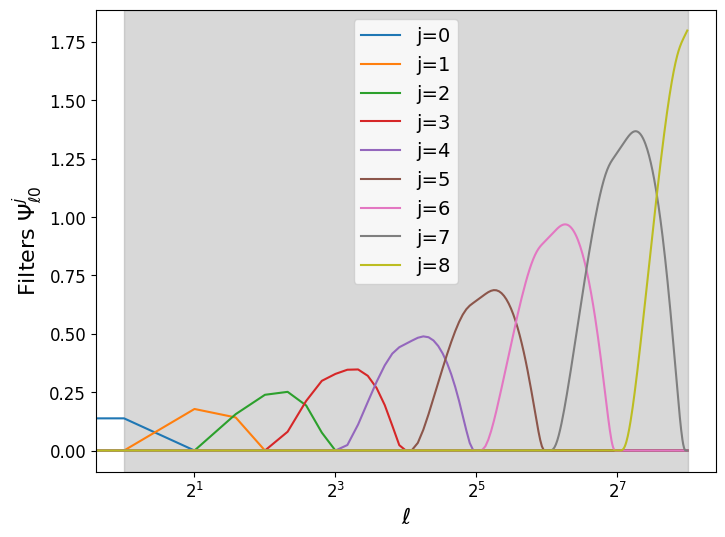

In [3]:
filters = filters_directional_vectorised(L, N, J_min)
plot.plot_filters(filters, real=False, m=L-2)
plt.axvspan(2**J_min, 2**J_max, color='grey', alpha=0.3)

# Take the wavelets only, not the scaling function
filters = filters[0]  

# Weights and precomps

In [4]:
weights = scatlib.quadrature(L, J_min, sampling, None, multiresolution)
precomps = scatlib.generate_full_precompute(
        L=L,
        N=N, 
        J_min=J_min, 
        sampling=sampling, 
        reality=reality, 
        multiresolution=multiresolution, 
        nside=None
    )

# Target map

In [5]:
### Sky
f_target, flm_target = sphlib.make_MW_lensing(L, normalize=True, reality=reality, dirmap="/home/mp2/Documents/Software/scatcovJAX/texture_maps/raw_data/")
print('Target = LSS map')

#f_target, flm_target = sphlib.make_pysm_sky(L, 'cmb', sampling=sampling, nest=False, normalize=True, reality=reality)
#print('Target = CMB map')

# f_target, flm_target = sphlib.make_planet(L, planet, normalize=True, reality=reality)
# print('Target = Planet map')

Target = LSS map


In [6]:
### Power spectrum of the target
ps_target = sphlib.compute_ps(flm_target)

### P00 for normalisation
tP00_norm = scatlib.get_P00only(flm_target, L, N, J_min, sampling, None,
                                reality, multiresolution, for_synthesis=False, normalisation=None,
                                filters=filters, quads=weights, precomps=precomps)  # [J][Norient]

### Scat coeffs S1, P00, C01, C11
# P00 is one because of the normalisation
tcoeffs = scatlib.scat_cov_dir(flm_target, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                       filters=filters, quads=weights, precomps=precomps)

tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs  # 1D arrays

In [ ]:
# Plot the map
mx, mn = np.nanmax(np.real(f_target)), np.nanmin(np.real(f_target))
plot.plot_map_MW_Mollweide(np.real(f_target), figsize=(8, 6), vmin=mn, vmax=mx)

In [7]:
print(tP00)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]


# Define the loss

In [8]:
#@jit
#def loss_func_ps_only(flm):
 #   ps = sphlib.compute_ps(flm)
  #  loss = synlib.chi2(ps_target, ps)
   # return loss

@jit
def loss_func_P00_only(flm):
    # flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    P00_new = scatlib.get_P00only(flm, L, N, J_min, sampling,
                          None, reality, multiresolution, for_synthesis=True,
                          normalisation=tP00_norm, filters=filters,
                          quads=weights, precomps=precomps)
    loss = synlib.chi2(tP00, P00_new)
    return loss


@jit
def loss_func(flm):
    # Make complex flm
    # flm = flm_float[0, :, :] + 1j * flm_float[1, :, :]
    
    mean_new, var_new, S1_new, P00_new, C01_new, C11_new = scatlib.scat_cov_dir(flm, L, N, J_min, sampling,
                                                                        None, reality, multiresolution,
                                                                        for_synthesis=True,
                                                                        normalisation=tP00_norm, filters=filters,
                                                                        quads=weights, precomps=precomps)
    # Control for mean + var
    loss = synlib.chi2(tmean, mean_new)
    loss += synlib.chi2(tvar, var_new)

    # Add S1, P00, C01, C11 losses
    loss += synlib.chi2(tS1, S1_new)
    loss += synlib.chi2(tP00, P00_new)
    loss += synlib.chi2(tC01, C01_new)
    loss += synlib.chi2(tC11, C11_new)

    return loss


# Initial condition

In [9]:
# Gaussian white noise in pixel space with the variance of the target
print(f'{tvar=}')
np.random.seed(42)
if reality:  # Real map
    f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64)
else:
    f = np.sqrt(tvar) * np.random.randn(L, 2 * L - 1).astype(np.float64) + 1j * np.random.randn(L, 2 * L - 1).astype(np.float64)

flm = s2fft.forward_jax(f, L, reality=reality)

# Cut the flm
flm = flm[:, L - 1:] if reality else flm

flm_start = jnp.copy(flm)  # Save the start point as we will iterate on flm

print('Starting loss', loss_func_P00_only(flm))
# print(scatlib.get_P00only(flm, L, N, J_min, sampling,
#                           None, reality, multiresolution, for_synthesis=True,
#                           normalisation=tP00_norm, filters=filters,
#                           quads=weights, precomps=precomps))

tvar=Array(0.99932588+0.j, dtype=complex128)
Starting loss 20.98974516605859


In [ ]:
plt.figure()
plt.imshow(np.imag(flm))
plt.colorbar()

# Run the synthesis

### Gradient descent à la main : on veut pas faire ça nous même

- Si je ne mets pas le conjugué, ça diverge.
- Avec le conjugué, ça descend lentement et le PS et la carte ne changent pas bcp

In [ ]:
# def fit_brutal(params, loss_func, momentum: float = 2., niter: int = 10, loss_history: list = None):
#     ### Gradient of the loss function
#     grad_loss_func = jit(grad(loss_func))
#
#     if loss_history is None:
#         loss_history = []
#     for i in range(niter):
#         start = time.time()
#         params -= momentum * np.conj(grad_loss_func(params))
#         #params -= momentum * grad_loss_func(params)
#         if i % 10 == 0:
#             end = time.time()
#             loss_value = loss_func(params)
#             loss_history.append(loss_value)
#             print(f"Iter {i}: Loss = {loss_value:.5f}, Momentum = {momentum}, Time = {end - start:.2f} s/iter")
#
#     return params, loss_history

In [ ]:
# niter = 400
# momentum = 1
# flm, loss_history = fit_brutal(flm, loss_func_P00_only, momentum=momentum, niter=niter, loss_history=None)

# flm_end = jnp.copy(flm)

### Using Optax

- Avec Adam, ca converge bien et le PS et la carte ont l'air ok

In [ ]:
# def fit_optax(params: optax.Params, optimizer: optax.GradientTransformation, loss_func,
#               niter: int = 10, loss_history: list = None) -> optax.Params:
#     ### Gradient of the loss function
#     grad_func = jit(grad(loss_func))
#
#     if loss_history is None:
#         loss_history = []
#     opt_state = optimizer.init(params)
#     for i in range(niter):
#         start = time.time()
#         grads = jnp.conj(grad_func(params))  # Take the conjugate of the gradient
#         #grads = grad_func(params)
#         updates, opt_state = optimizer.update(grads, opt_state, params)
#         params = optax.apply_updates(params, updates)
#         end = time.time()
#         if i % 10 == 0:
#             loss_value = loss_func(params)
#             loss_history.append(loss_value)
#             print(f'Iter {i}, Loss: {loss_value:.10f}, Time = {end - start:.10f} s/iter')
#
#     return params, loss_history

In [10]:
niter = 200
lr = 1e-2
#optimizer = optax.fromage(lr)
optimizer = optax.adam(lr)
#optimizer = optax.adagrad(lr)
flm, loss_history = synlib.fit_optax(flm, optimizer, loss_func_P00_only, niter=niter, loss_history=None)

flm_end = jnp.copy(flm)

Iter 0, Loss: 15.9789417703, Time = 13.6912336349 s/iter
Iter 10, Loss: 1.5104138485, Time = 0.0070831776 s/iter
Iter 20, Loss: 0.5124963230, Time = 0.0070316792 s/iter
Iter 30, Loss: 0.1079631351, Time = 0.0062923431 s/iter
Iter 40, Loss: 0.0673353508, Time = 0.0044345856 s/iter
Iter 50, Loss: 0.0288785255, Time = 0.0043864250 s/iter
Iter 60, Loss: 0.0115571588, Time = 0.0043785572 s/iter
Iter 70, Loss: 0.0021809667, Time = 0.0043196678 s/iter
Iter 80, Loss: 0.0016326149, Time = 0.0043399334 s/iter
Iter 90, Loss: 0.0003518431, Time = 0.0044226646 s/iter
Iter 100, Loss: 0.0001411126, Time = 0.0044827461 s/iter
Iter 110, Loss: 0.0000518930, Time = 0.0044357777 s/iter
Iter 120, Loss: 0.0000255380, Time = 0.0048723221 s/iter
Iter 130, Loss: 0.0000080289, Time = 0.0045468807 s/iter
Iter 140, Loss: 0.0000034336, Time = 0.0042300224 s/iter
Iter 150, Loss: 0.0000007078, Time = 0.0042192936 s/iter
Iter 160, Loss: 0.0000001353, Time = 0.0055823326 s/iter
Iter 170, Loss: 0.0000001030, Time = 0.0

In [11]:
niter = 200
lr = 1e-2
#optimizer = optax.fromage(lr)
optimizer = optax.adam(lr)
#optimizer = optax.adagrad(lr)
flm, loss_history = synlib.fit_optax(flm, optimizer, loss_func, niter=niter, loss_history=None)

flm_end = jnp.copy(flm)

Iter 0, Loss: 389588.7126136454, Time = 82.5800509453 s/iter
Iter 10, Loss: 17816.3351028118, Time = 0.0356779099 s/iter
Iter 20, Loss: 5545.9589673614, Time = 0.0310394764 s/iter
Iter 30, Loss: 1619.4895231919, Time = 0.0311887264 s/iter
Iter 40, Loss: 1434.6667065007, Time = 0.0312056541 s/iter
Iter 50, Loss: 1334.7812345074, Time = 0.0311307907 s/iter
Iter 60, Loss: 1093.9990619211, Time = 0.0310373306 s/iter
Iter 70, Loss: 965.9258422165, Time = 0.0311894417 s/iter
Iter 80, Loss: 879.9521484610, Time = 0.0312092304 s/iter
Iter 90, Loss: 805.4418097892, Time = 0.0306503773 s/iter
Iter 100, Loss: 741.8469747320, Time = 0.0312526226 s/iter
Iter 110, Loss: 682.7746217049, Time = 0.0313117504 s/iter
Iter 120, Loss: 631.7853201837, Time = 0.0312037468 s/iter
Iter 130, Loss: 585.9019549253, Time = 0.0312421322 s/iter
Iter 140, Loss: 544.2936099727, Time = 0.0313348770 s/iter
Iter 150, Loss: 506.4178152915, Time = 0.0314984322 s/iter
Iter 160, Loss: 471.8403161129, Time = 0.0310986042 s/it

### Using Jaxopt

- Methods : GradientDescent ou LBFGS
- Ne marche pas avec des complexes, c'est pour ça que la loss divergeait systématiquement.
- Avec LBFGS, il est bcp + lent que Jaxopt.scipy.minimize('LBFGS')

In [ ]:
def fit_jaxopt(params, loss_func, method='LBFGS', niter: int = 10, loss_history: list = None):
    print('Starting loss:', loss_func(params))
    
    if method == 'LBFGS':
        optimizer = jaxopt.LBFGS(fun=loss_func, jit=True)
    elif method == 'GradientDescent':
        optimizer = jaxopt.GradientDescent(fun=loss_func, jit=True)
    
    if loss_history is None:
        loss_history = []
        loss_history.append(loss_func(params))
        
    opt_state = optimizer.init_state(params)
    for i in range(niter):
        start = time.time()
        params, opt_state = optimizer.update(params, opt_state)
        end = time.time()
        if i % 10 == 0:
            loss_value = loss_func(params)
            loss_history.append(loss_value)
            print(f'Iter {i}, Loss: {loss_value:.10f}, Time = {end - start:.10f} s/iter')

    return params, loss_history

In [ ]:
flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)])

In [ ]:
flm, loss_history = fit_jaxopt(flm_float, loss_func, method='GradientDescent', niter=300, loss_history=None)

# flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]

In [ ]:
for l in range(L):
    print(flm_target[l,L-2],flm_start[l,L-2],flm_end[l,L-2], "\n")

### Using jaxopt Scipy

- Methods: CG, Newton-CG, L-BFGS-B
- Ca ne marche pas avec des complexes. Par défaut, il convertit les arrays en float 64. Résultat on a une carte output symmétrique parce que la partie Im des flm est mise à 0. 
- Si on itère sur les parties Re et Im ça marche. 

In [ ]:
def fit_jaxopt_Scipy(params, loss_func, method='L-BFGS-B', niter: int = 10, loss_history: list = None):
    
    if loss_history is None:
        loss_history = []
        loss_history.append(loss_func(params))
    
    optimizer = jaxopt.ScipyMinimize(fun=loss_func, method=method, jit=True, maxiter=1)
    
    for i in range(niter):
        start = time.time()
        params, opt_state = optimizer.run(params)
        end = time.time()
        if i % 10 == 0:
            loss_history.append(opt_state.fun_val)
            print(f'Iter {i}, Success: {opt_state.success}, Loss = {opt_state.fun_val}, Time = {end - start:.10f} s/iter')
        
    return params, loss_history

In [ ]:
### P00 only
flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)])  # [2, L, L]     

flm, loss_history = fit_jaxopt_Scipy(flm_float, loss_func_P00_only, method='L-BFGS-B', niter=300, loss_history=None)

#flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]

In [ ]:
### All coeffs
flm = jnp.array([jnp.real(flm), jnp.imag(flm)]) # [2, L, L]          

flm, loss_history = fit_jaxopt_Scipy(flm, loss_func, method='L-BFGS-B', niter=300, loss_history=None)

#flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]

In [ ]:
### P00 and then all coeffs
flm_float = jnp.array([jnp.real(flm), jnp.imag(flm)]) # [2, L, L]          

flm, loss_historyP00 = fit_jaxopt_Scipy(flm_float, loss_func_P00_only, method='L-BFGS-B', niter=300, loss_history=None)

flm, loss_history = fit_jaxopt_Scipy(flm, loss_func, method='L-BFGS-B', niter=300, loss_history=loss_historyP00)

#flm_end = jnp.copy(flm)
flm_end = flm[0, :, :] + 1j * flm[1, :, :]


In [ ]:
# plt.figure()
# plt.title('flm_end Im part')
# plt.imshow(np.imag(flm_end))
# plt.colorbar()

# Check the synthesis

In [ ]:
# Coeffs

scoeffs = scatlib.scat_cov_dir(flm_start, L, N, J_min, sampling, None,
                           reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                           filters=filters, quads=weights, precomps=precomps)
ecoeffs = scatlib.scat_cov_dir(flm_end, L, N, J_min, sampling, None,
                       reality, multiresolution, for_synthesis=True, normalisation=tP00_norm,
                       filters=filters, quads=weights, precomps=precomps)


tmean, tvar, tS1, tP00, tC01, tC11 = tcoeffs
smean, svar, sS1, sP00, sC01, sC11 = scoeffs
emean, evar, eS1, eP00, eC01, eC11 = ecoeffs

In [ ]:
print(flm_target.shape, flm_start.shape, flm_end.shape)

In [ ]:
flm_target

In [ ]:
### Cut the flm that are not contrained
flm_target = flm_target.at[0: 2**J_min + 1, :].set(0. + 0.j)

In [ ]:
flm_target

In [ ]:
# Make the maps
f_target = s2fft.inverse_jax(flm_target, L, reality=reality)
f_start = s2fft.inverse_jax(flm_start, L, reality=reality)
f_end = s2fft.inverse_jax(flm_end, L, reality=reality)

# Mean and var

In [ ]:
print('Mean:', tmean, smean, emean)
print('Var:', tvar, svar, evar)

### Plot the loss

In [ ]:
nit1 = 0
nit2 = 300
step = 1

plt.figure(figsize=(8, 6))
#plt.plot(np.arange(0, nit1+1, step), loss_history[:int(nit1/step)+1], 'bo--', label='P00 only')
# plt.plot(np.arange(nit1, nit1 + nit2, step), loss_history[int(nit2/step)+1:], 'ro--', label='All coeffs')
plt.plot(np.arange(nit1, nit1 + nit2 + 1, step), loss_history, 'ro--', label='All coeffs')

plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Number of iterations')
plt.legend()

In [ ]:
#mn, mx = np.nanmin(f_target), np.nanmax(f_target)
mn, mx = -1, 3
#mn, mx = None, None

fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize=(10,3))
ax1.imshow(np.real(f_target), vmax=mx, vmin=mn, cmap='viridis')
ax2.imshow(np.real(f_start), vmax=mx, vmin=mn, cmap='viridis')
ax3.imshow(f_end, vmax=mx, vmin=mn, cmap='viridis')
plt.show()

In [ ]:
plot.plot_map_MW_Mollweide(f_target, vmin=mn, vmax=mx, title=f'Target - {mn=:.2f}, {mx=:.2f}', figsize=(10, 6))

In [ ]:
plot.plot_map_MW_Mollweide(f_end, vmin=mn, vmax=mx, title='', figsize=(10, 6))#f'End - {mn=:.2f}, {mx=:.2f}', )

### Power spectrum

In [ ]:
ps_target = sphlib.compute_ps(flm_target)
ps_start = sphlib.compute_ps(flm_start)
ps_end = sphlib.compute_ps(flm_end)

plt.figure(figsize=(8, 6))
plt.plot(ps_target, 'b', label="Target")
plt.plot(ps_start, 'g', label="Start")
plt.plot(ps_end, 'r', label="End")
plt.yscale("log")
plt.xlabel(r'Multipole $\ell$')
plt.ylabel('Power spectrum')
plt.grid()
#plt.xlim(2, 64)
plt.ylim(1e-4, 1)
plt.legend()

### Plot the coefficients

In [ ]:
plot.plot_scatcov_coeffs(tS1, tP00, tC01, tC11, name='Target', hold=True, color='blue')

plot.plot_scatcov_coeffs(sS1, sP00, sC01, sC11, name='Start', hold=False, color='green')

plot.plot_scatcov_coeffs(eS1, eP00, eC01, eC11, name='End', hold=False, color='red')